# Pose Detection in Images and on Videos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from time import time
import cv2
import mediapipe as mp

# Initialize MediaPipe Pose.
mp_pose = mp.solutions.pose
# Setting up the Pose function
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5, model_complexity=2)
# Initialize MediaPipe Drawing, useful for annotating the image.
mp_drawing = mp.solutions.drawing_utils

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


* **static_image_mode** – It is a boolean value that is if set to `False`, the detector is only invoked as needed, that is in the very first frame or when the tracker loses track. If set to `True`, the person detector is invoked on every input image. So you should probably set this value to `True` when working with a bunch of unrelated images not videos. Its default value is `False`.
* **min_detection_confidence** – It is the minimum detection confidence with range `(0.0 , 1.0)` required to consider the person-detection model’s prediction correct. Its default value is `0.5`. This means if the detector has a prediction confidence of greater or equal to 50% then it will be considered as a positive detection.
* **min_tracking_confidence** – It is the minimum tracking confidence `([0.0, 1.0])` required to consider the landmark-tracking model’s tracked pose landmarks valid. If the confidence is less than the set value then the detector is invoked again in the next frame/image, so increasing its value increases the robustness, but also increases the latency. Its default value is `0.5`.
* **model_complexity** – It is the complexity of the pose landmark model. As there are three different models to choose from so the possible values are `0, 1, or 2`. The higher the value, the more accurate the results are, but at the expense of higher latency. Its default value is `1`.
* **smooth_landmarks** – It is a boolean value that is if set to `True`, pose landmarks across different frames are filtered to reduce noise. But only works when static_image_mode is also set to `False`. Its default value is `True`.

## Read an Image

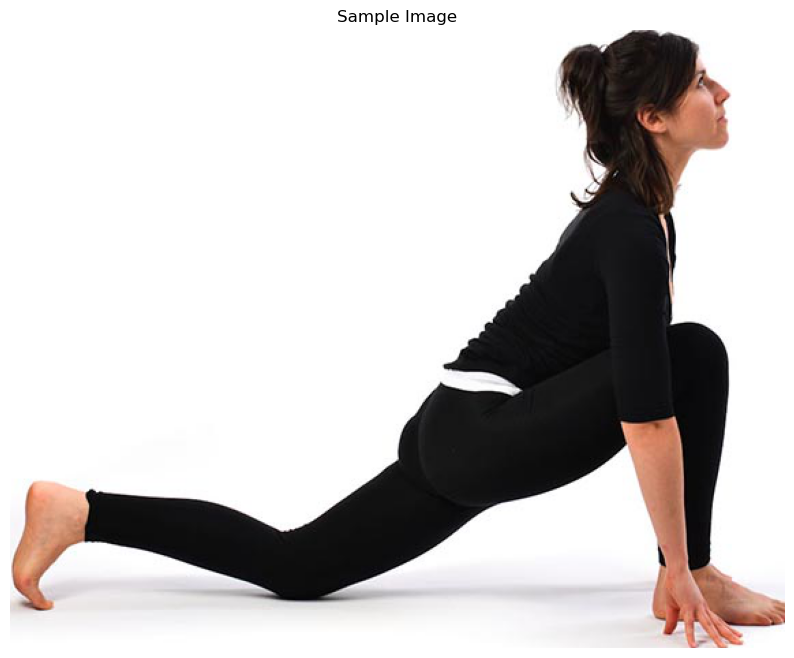

In [2]:
cap = cv2.imread('../Data/Yoga_Datasets/Anjaneyasana/File1.png')

# Specify a size of the image
plt.figure(figsize=[10,10])

# Display the sample image
plt.title('Sample Image')
plt.axis('off')
plt.imshow(cap[:,:,::-1])
plt.show()

## Perform Pose Detection

the pipeline expects the input images in RGB color format so first we will have to convert the sample image from BGR to RGB format using the function cv2.cvtColor() as OpenCV reads images in BGR format (instead of RGB).

In [4]:
# Perform pose detection after converting the BGR image to RGB.
results = pose.process(cv2.cvtColor(cap, cv2.COLOR_BGR2RGB))

# Check if any landmarks are detected.
if results.pose_landmarks:
    # Iterate 2 times as we only want to display the first 2 landmarks.
    for i in range(2):
        # Display the found landmarks.
        print(f'{mp_pose.PoseLandmark(i).name}:\n{results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value]}')

NOSE:
x: 0.9237393736839294
y: 0.12947750091552734
z: -0.096354179084301
visibility: 0.9997711777687073

LEFT_EYE_INNER:
x: 0.9045822620391846
y: 0.10319387912750244
z: -0.07098434865474701
visibility: 0.9997444748878479



* **x** – It is the landmark x-coordinate normalized to [0.0, 1.0] by the image width.
* **y**: It is the landmark y-coordinate normalized to [0.0, 1.0] by the image height.
* **z**: It is the landmark z-coordinate normalized to roughly the same scale as x. It represents the landmark depth with midpoint of hips being the origin, so the smaller the value of z, the closer the landmark is to the camera.
* **visibility**: It is a value with range [0.0, 1.0] representing the possibility of the landmark being visible (not occluded) in the image. This is a useful variable when deciding if you want to show a particular joint because it might be occluded or partially visible in the image.

In [5]:
# Now we will convert the two normalized landmarks displayed above into their original scale by using 
# the width and height of the image.

# Retrieve the width and height of the image.
image_height, image_width, _ = cap.shape

# Check if any landmarks are detected.
if results.pose_landmarks:
    for i in range(2):
        print(f'{mp_pose.PoseLandmark(i).name}:')
        print(f'X-coordinate: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].x * image_width}')
        print(f'Y-coordinate: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].y * image_height}')
        print(f'Z-coordinate: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].z * image_width}')
        print(f'Visibility: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].visibility}')

NOSE:
X-coordinate: 524.6839642524719
Y-coordinate: 58.65330791473389
Z-coordinate: -54.729173719882965
Visibility: 0.9997711777687073
LEFT_EYE_INNER:
X-coordinate: 513.8027248382568
Y-coordinate: 46.746827244758606
Z-coordinate: -40.3191100358963
Visibility: 0.9997444748878479


Now we will draw the detected landmarks on the sample image using the function `mp.solutions.drawing_utils.draw_landmarks()` and display the resultant image using the matplotlib library.

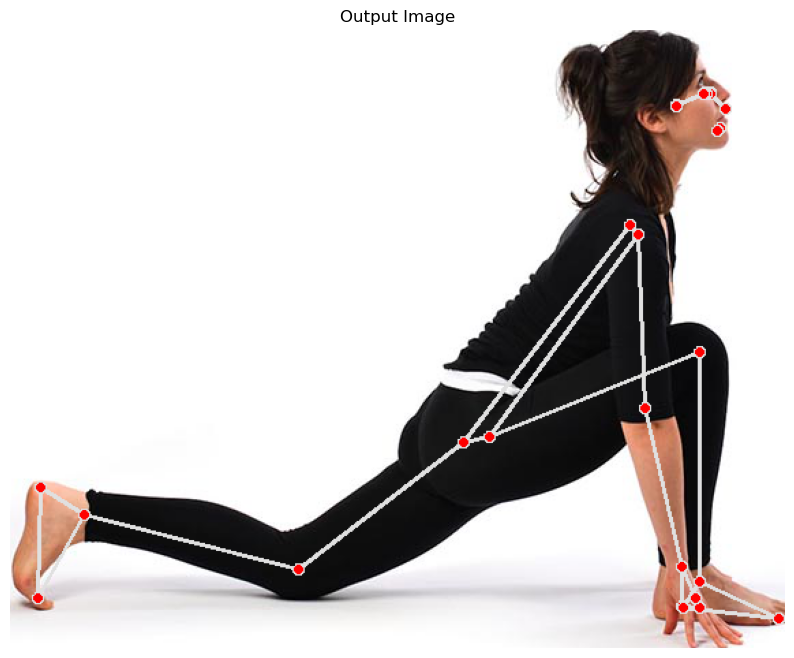

In [6]:
img_copy = cap.copy()

if results.pose_landmarks:
    # Draw the pose annotation on the image.
    mp_drawing.draw_landmarks(img_copy, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
    # Specify a size of the image
    fig = plt.figure(figsize=[10,10])
    # Display the output image with the landmarks drawn on it.
    plt.title('Output Image')
    plt.axis('off')
    plt.imshow(img_copy[:,:,::-1])
    plt.show()

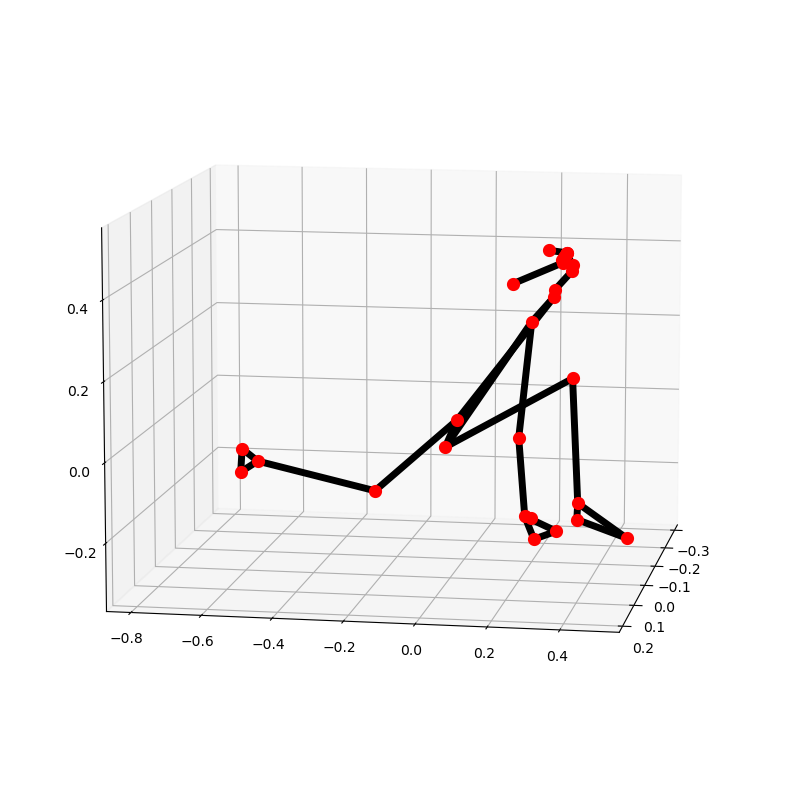

In [7]:
# Plot Pose Landmarks in 3D
mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

## Create a Pose Detection Function for Images

In [8]:
def detectPose(image, pose, display=True):
    # Create a copy of the image.
    output_image = image.copy()
    
    # Convert the BGR image to RGB.
    imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Perform pose detection.
    results = pose.process(imageRGB)
    
    # Retrieve the width and height of the image.
    height, width, _ = image.shape
    
    # Initialize a list to store the detected landmarks.
    landmarks = []
    
    # Check if any landmarks are detected.
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(output_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
        # Iterate over all the detected landmarks.
        for landmark in results.pose_landmarks.landmark:
            # Append the landmark to the list.
            landmarks.append((int(landmark.x * width), int(landmark.y * height), int(landmark.z * width)))
            
        # Check if the output image needs to be displayed.
        if display:
            plt.figure(figsize=[22,22])
            plt.subplot(121); plt.imshow(image[:,:,::-1]); plt.title('Input Image'); plt.axis('off');
            plt.subplot(122); plt.imshow(output_image[:,:,::-1]); plt.title('Output Image'); plt.axis('off');
            # Plot the Pose Landmarks in 3D.
            mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)
        else:
            # Return the output image and the detected landmarks.
            return output_image, landmarks

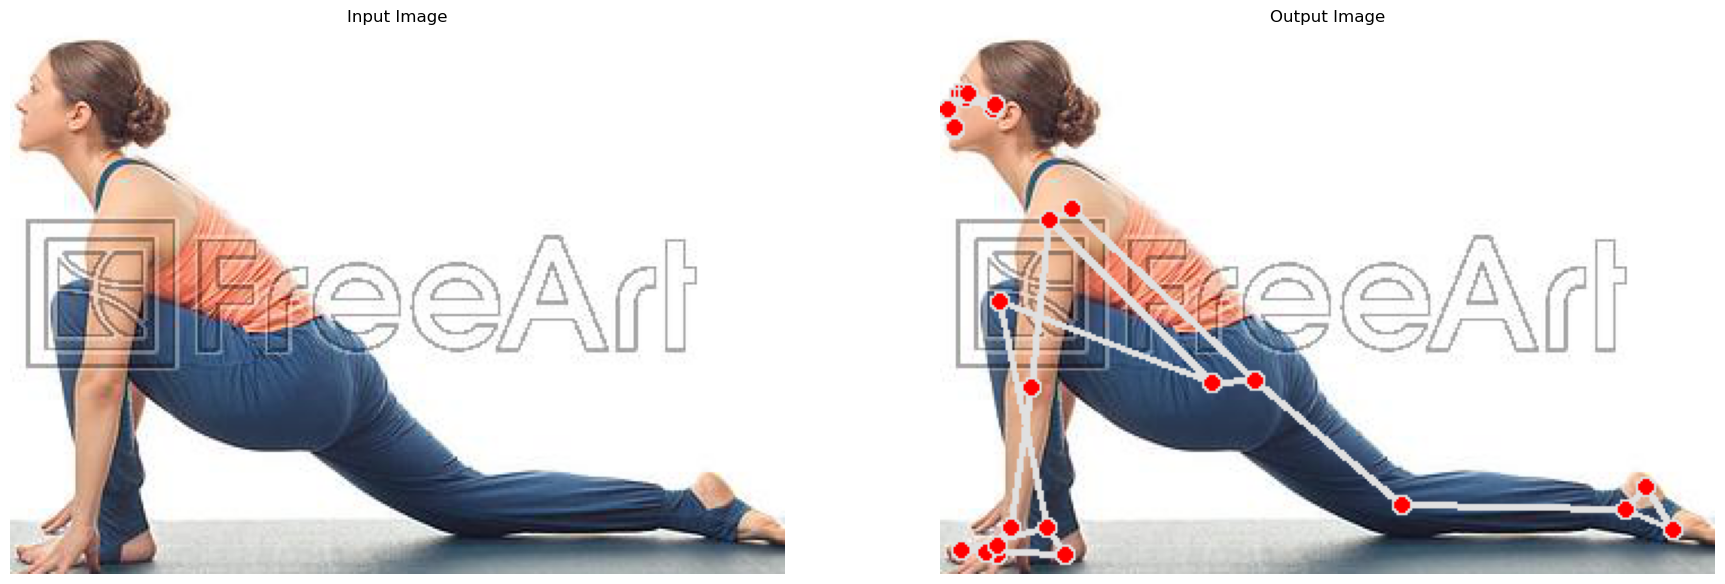

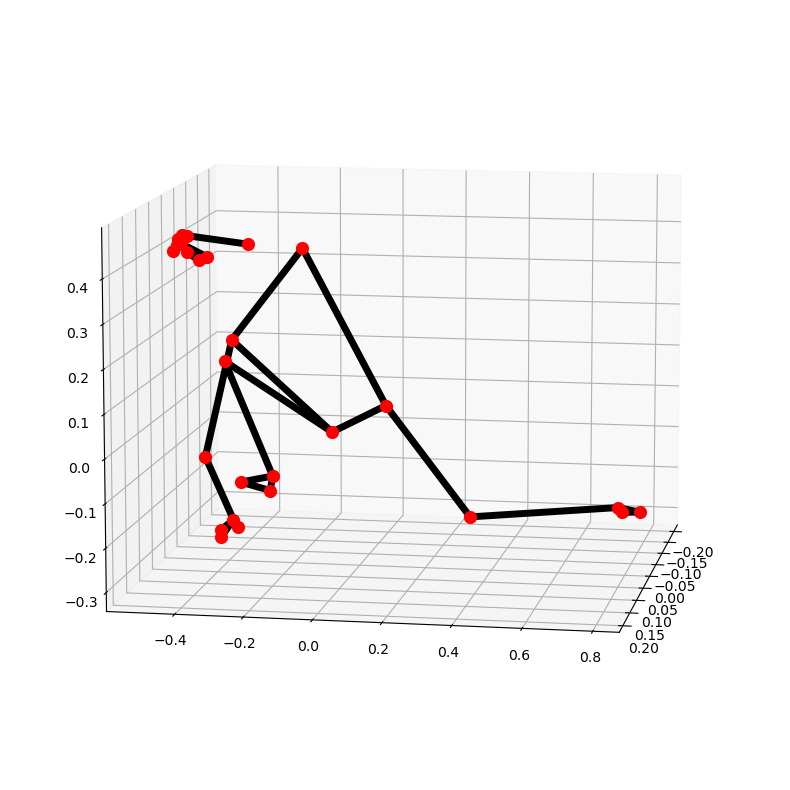

In [9]:
# Read anothe sample image and perform pose detection.
image = cv2.imread('../Data/Yoga_Datasets/Anjaneyasana/File2.png')
detectPose(image, pose, display=True)

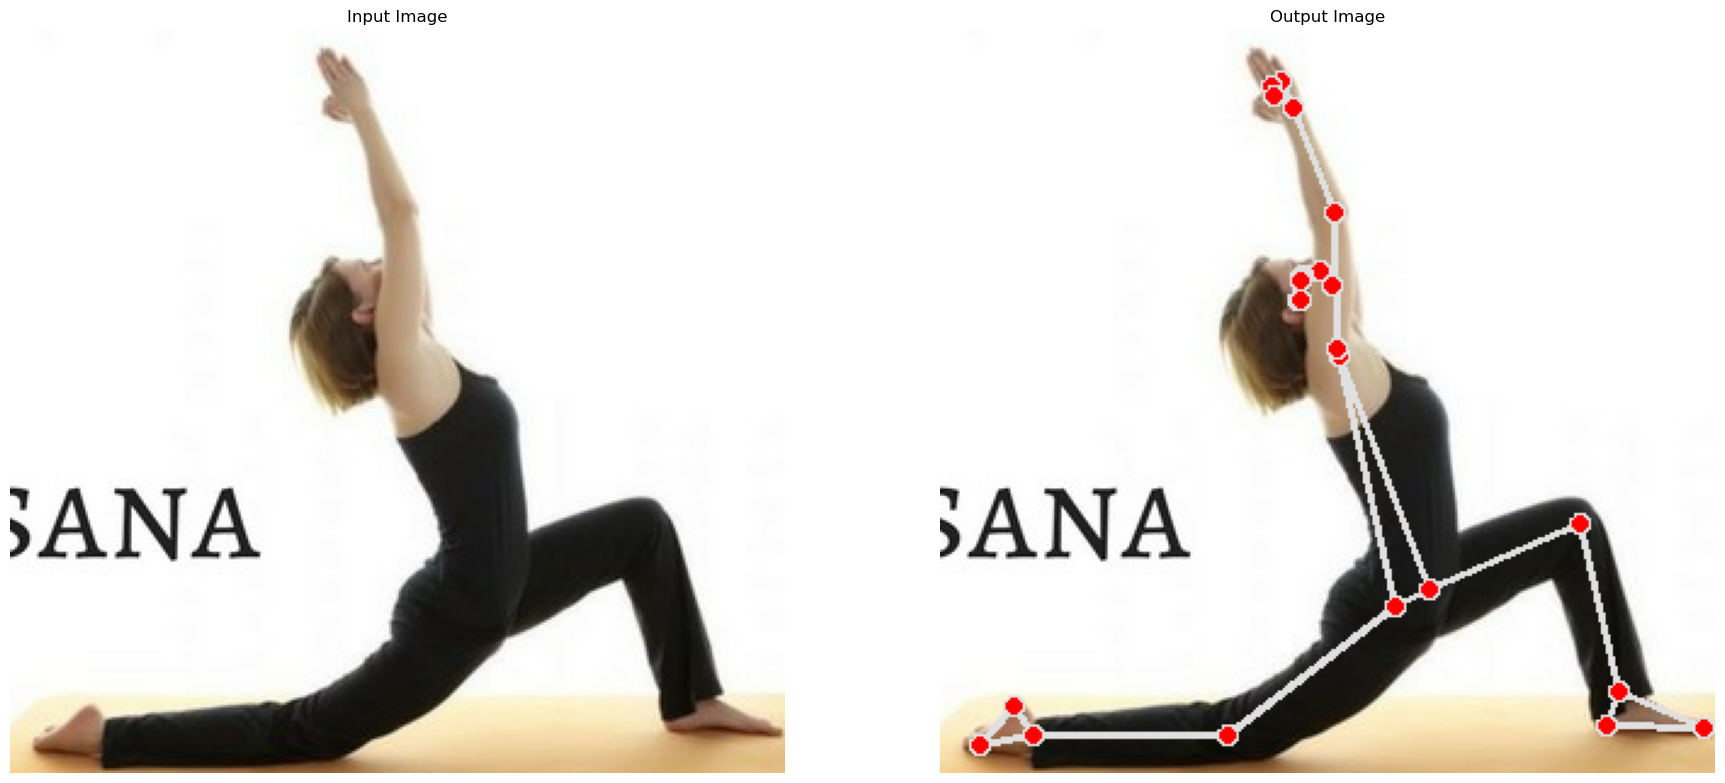

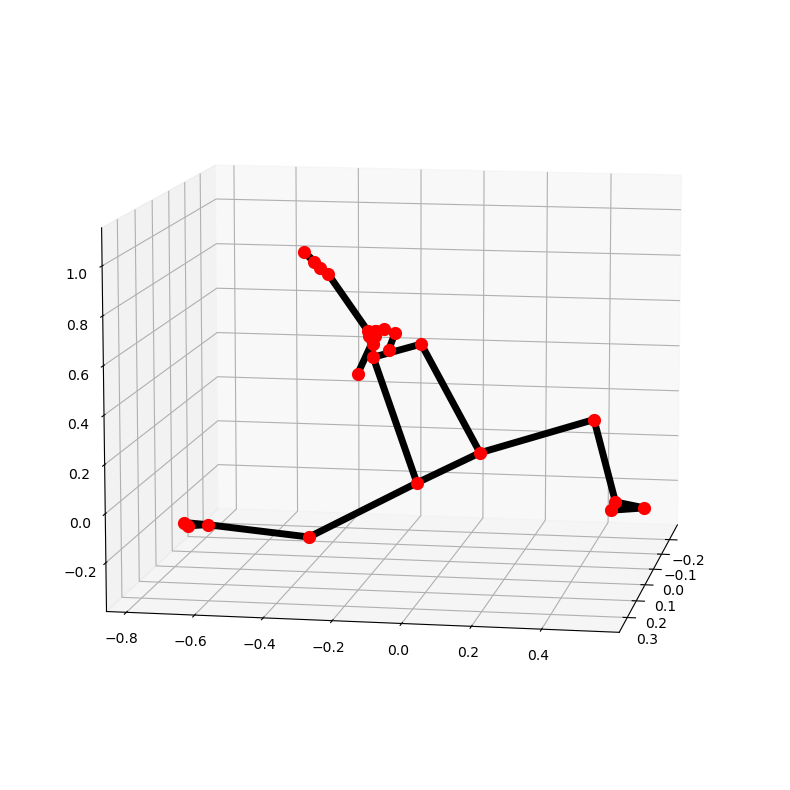

In [20]:
# Read anothe sample image and perform pose detection.
image = cv2.imread('../Data/Yoga_Datasets/Anjaneyasana/File13.png')
detectPose(image, pose, display=True)

## Pose Detection On Real-Time Webcam Feed/Video

In [26]:
pose_video = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, model_complexity=1)
video = cv2.VideoCapture('../Data/1.mp4')

# Intialize a variable to store the frame count.
time1 = 0

# Iterate until the video is accessed 
while video.isOpened():
    # Read the video frame.
    ok, frame = video.read()
    # Check if frame is not read properly.
    if not ok:
        break
    
    # Flip the frame horizontally for natural (selfie-view) visualization.
    frame = cv2.flip(frame, 1)
    frame_height, frame_width, _ = frame.shape
    # Resize the frame while maintaining the aspect ratio.
    frame = cv2.resize(frame, (int(frame_width * (640/frame_height)), 640))
    # Perform pose detection.
    frame, _ = detectPose(frame, pose_video, display=False)
    # Set the time for this frame to the current time.
    time2 = time()
    
    # # Check if the difference between the current time and the previous time is greater than 1/24.
    # if (time2 - time1) &gt== 0:
    #     frames_per_second = 1.0/(time2 - time1)
    #     # Write the calculated no of frames per second on the frame.
    #     cv2.putText(frame, f'FPS: {int(frames_per_second)}', (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        
    # Update the previous time to the current time.
    time1 = time2
    # Display the frame.
    cv2.imshow('Pose Detection', frame)
    
    # Retrieve the ASCII code of the key pressed on the keyboard.
    k = cv2.waitKey(1) & 0xFF
    if(k == 27):
        # If the key pressed is ESC, exit the loop.
        break
# Release the VideoCapture object.
video.release()
cv2.destroyAllWindows() # Close all the windows.

[ WARN:0@4077.454] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d9lyif19nl/croot/opencv-suite_1676472756314/work/modules/videoio/src/cap_gstreamer.cpp (2386) handleMessage OpenCV | GStreamer warning: your GStreamer installation is missing a required plugin
[ WARN:0@4077.454] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d9lyif19nl/croot/opencv-suite_1676472756314/work/modules/videoio/src/cap_gstreamer.cpp (2402) handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module uridecodebin3 reported: Your GStreamer installation is missing a plug-in.
[ WARN:0@4077.455] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d9lyif19nl/croot/opencv-suite_1676472756314/work/modules/videoio/src/cap_gstreamer.cpp (1356) open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0@4077.455] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d9lyif19nl/croot/opencv-suite_1676472756314/work/modules/v

: 